# How to - Iterative multi-angle images fusion

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import numpy as np
from timagetk.algorithms.blockmatching import blockmatching
from timagetk.tasks.fusion import iterative_fusion
from timagetk.algorithms.pointmatching import pointmatching
from timagetk.algorithms.resample import resample
from timagetk.algorithms.trsf import inv_trsf
from timagetk.algorithms.trsf import create_trsf
from timagetk.io import imread
from timagetk.io.image import _image_from_url
from timagetk.visu.stack import stack_browser
from timagetk.visu.stack import orthogonal_view
from timagetk.visu.mplt import grayscale_imshow

## Get the shared multi-angle intensity images

To access the shared multi-angle intensity images, we use 3 *view angle images* from the first time-point of the `p58` time-serie.

In [6]:
file_urls = [
    "https://zenodo.org/record/7151866/files/090223-p58-flo-top.lsm",
    "https://zenodo.org/record/7151866/files/090223-p58-flo-tilt1.lsm",
    "https://zenodo.org/record/7151866/files/090223-p58-flo-tilt2.lsm"
]
file_hashs = [
    "5548917d3d1490200d0d56cbb31c0d35",
    "fa004a84100fcd5ff1d2f9d7c5cbda30",
    "006bf3bacb667eb72d0fb9a6419edcc1"
]

In [ ]:
fnames = [_image_from_url(url ,hash_value=md5_hash, hash_method='md5') for url, md5_hash in zip(file_urls, file_hashs)]

## Load the multi-angle images:

In [12]:
img_list = [imread(fname) for fname in fnames]

We use the first image of the list, which is a 'top' view, as the **initial reference image**.

In [13]:
ref_img = img_list[0]
float_imgs = img_list[1:]

## Down-sample the images to speed-up the computations

In [14]:
print("# - Voxelsize (ZYX) for the initial image list:")
print("\n".join([f"Image '{im.filename}' (#{n}): {im.voxelsize}" for n, im in enumerate(img_list)]))
print("# - Shape (ZYX) for the initial image list:")
print("\n".join([f"Image '{im.filename}' (#{n}): {im.shape}" for n, im in enumerate(img_list)]))

# - Voxelsize (ZYX) for the initial image list:
Image '090223-p58-flo-top.lsm' (#0): [1.0, 0.20031953747828882, 0.20031953747828882]
Image '090223-p58-flo-tilt1.lsm' (#1): [1.0, 0.20031953747828882, 0.20031953747828882]
Image '090223-p58-flo-tilt2.lsm' (#2): [1.0, 0.20031953747828882, 0.20031953747828882]
# - Shape (ZYX) for the initial image list:
Image '090223-p58-flo-top.lsm' (#0): (59, 460, 460)
Image '090223-p58-flo-tilt1.lsm' (#1): (50, 460, 460)
Image '090223-p58-flo-tilt2.lsm' (#2): (54, 460, 460)


In [15]:
img_list = [resample(im, voxelsize=[1., 0.5, 0.5]) for im in img_list]

2022-10-06 09:59:01,699 - timagetk.algorithms.resample - 159 - INFO - Resampling using provided voxel-sizes: [1.0, 0.5, 0.5]
2022-10-06 09:59:01,955 - timagetk.algorithms.resample - 159 - INFO - Resampling using provided voxel-sizes: [1.0, 0.5, 0.5]
2022-10-06 09:59:02,201 - timagetk.algorithms.resample - 159 - INFO - Resampling using provided voxel-sizes: [1.0, 0.5, 0.5]


In [16]:
print("# - Voxelsize (ZYX) for the resampled image list:")
print("\n".join([f"Image '{im.filename}' (#{n}): {im.voxelsize}" for n, im in enumerate(img_list)]))
print("# - Shape (ZYX) for the resampled image list:")
print("\n".join([f"Image '{im.filename}' (#{n}): {im.shape}" for n, im in enumerate(img_list)]))

# - Voxelsize (ZYX) for the resampled image list:
Image '090223-p58-flo-top.lsm' (#0): [1.0, 0.5, 0.5]
Image '090223-p58-flo-tilt1.lsm' (#1): [1.0, 0.5, 0.5]
Image '090223-p58-flo-tilt2.lsm' (#2): [1.0, 0.5, 0.5]
# - Shape (ZYX) for the resampled image list:
Image '090223-p58-flo-top.lsm' (#0): (59, 184, 184)
Image '090223-p58-flo-tilt1.lsm' (#1): (50, 184, 184)
Image '090223-p58-flo-tilt2.lsm' (#2): (54, 184, 184)


## Intensity projections for multi-angle images

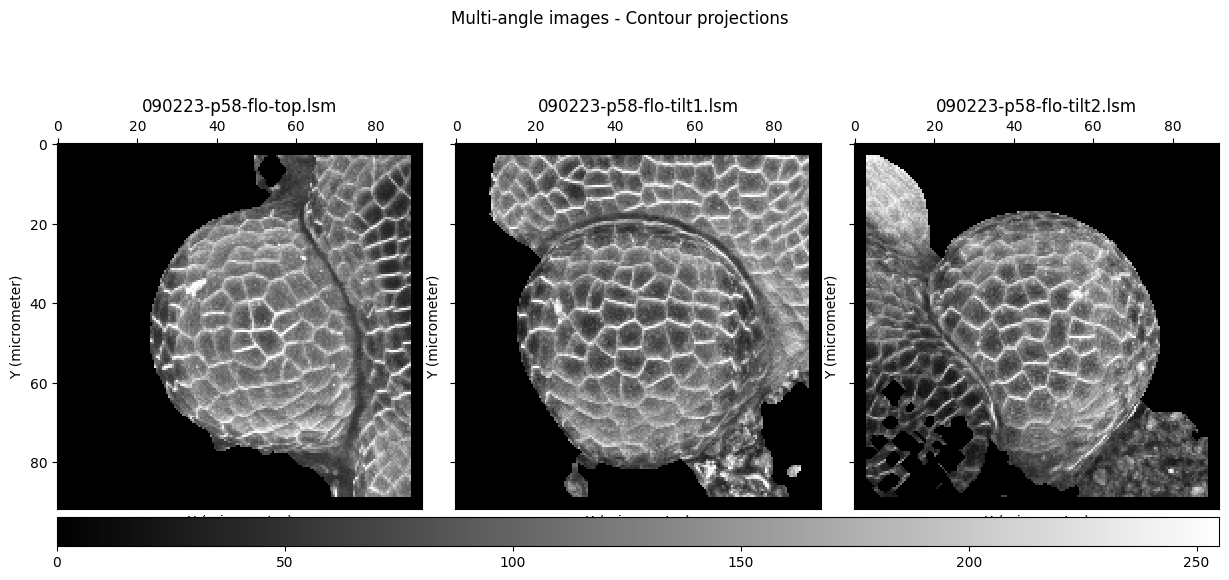

In [17]:
f = grayscale_imshow(img_list, suptitle="Multi-angle images - Contour projections", title=[img.filename for img in img_list], val_range=[0, 255], threshold=40)

## Load the manual registration landmarks

As the angles between the "views" is important, we start with a manual initialisation using landmarks.

In [18]:
flo_pts_01 = np.loadtxt('p58_t0_floating_ldmk-01.txt')
flo_pts_02 = np.loadtxt('p58_t0_floating_ldmk-02.txt')
ref_pts_01 = np.loadtxt('p58_t0_reference_ldmk-01.txt')
ref_pts_02 = np.loadtxt('p58_t0_reference_ldmk-02.txt')

## Create manual initial transformations with `pointmatching` algorithm

In [19]:
man_trsf_01 = pointmatching(flo_pts_01, ref_pts_01, template_img=ref_img, method='rigid')
man_trsf_02 = pointmatching(flo_pts_02, ref_pts_02, template_img=ref_img, method='rigid')
init_trsfs = [man_trsf_01, man_trsf_02]

## Iterative fusion

### Fast iterative fusion

In this version of iterative fusion, we performs a vectorfield registration **ONLY** for the last iteration step to save computation & time.

In [20]:
vf_fused_img = iterative_fusion(img_list, init_trsfs=init_trsfs, vectorfield_at_last=True)

2022-10-06 10:01:02,950 - timagetk.tasks.fusion - 208 - INFO - Initial rigid registration on the first image of the list...
2022-10-06 10:01:02,954 - timagetk.algorithms.blockmatching - 290 - INFO - RIGID registration with a 'left' initialisation matrix
2022-10-06 10:01:03,392 - timagetk.algorithms.blockmatching - 290 - INFO - RIGID registration with a 'left' initialisation matrix
2022-10-06 10:01:03,830 - timagetk.tasks.fusion - 214 - INFO - Fusion - Initial registration (iteration 0)...
2022-10-06 10:01:03,831 - timagetk.tasks.fusion - 476 - INFO - Reference image shape: [59, 184, 184]
2022-10-06 10:01:03,831 - timagetk.tasks.fusion - 477 - INFO - Reference image voxel-sizes: [1.0, 0.5, 0.5]
2022-10-06 10:01:03,832 - timagetk.tasks.fusion - 479 - INFO - Floating image #0 shape: [50, 184, 184]
2022-10-06 10:01:03,833 - timagetk.tasks.fusion - 480 - INFO - Floating image #0 voxel-sizes: [1.0, 0.5, 0.5]
2022-10-06 10:01:03,833 - timagetk.tasks.fusion - 479 - INFO - Floating image #1 sha

2022-10-06 10:01:14,890 - timagetk.tasks.fusion - 593 - INFO - Fused image voxel-sizes: [1.0, 1.0, 1.0]
2022-10-06 10:01:14,891 - timagetk.tasks.fusion - 596 - INFO - Multi-angle fusion done in 4.847s


In [21]:
print(f"Fused image voxel-size: {vf_fused_img.get_voxelsize()}")
print(f"Fused image shape: {vf_fused_img.get_shape()}")

Fused image voxel-size: [1.0, 1.0, 1.0]
Fused image shape: [60, 92, 92]


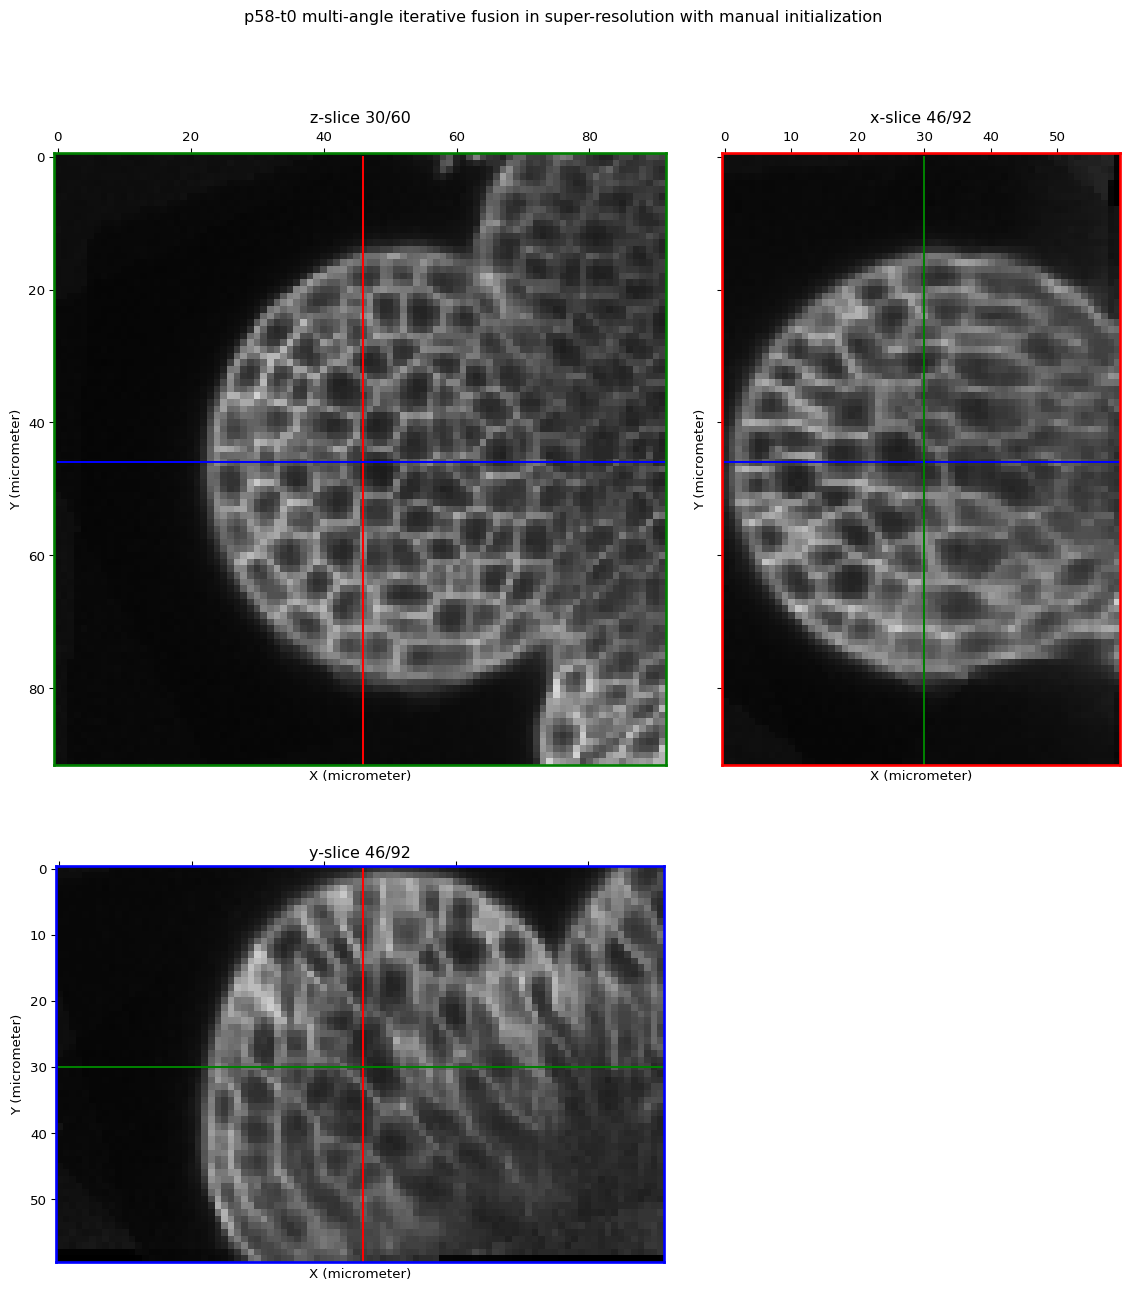

In [22]:
orthogonal_view(vf_fused_img, figsize=(15, 15), suptitle="p58-t0 multi-angle iterative fusion in super-resolution with manual initialization")